# Projeto Spark

A ser realizado em duplas.

Entrega: 6 de dezembro de 2022

## Introdução

Neste projeto vamos construir um classificador Naive-Bayes para determinar o sentimento de um comentário.

## Instalando o ambiente

O jeito mais simples de começar a trabalhar com Spark é instalar um container com tudo pronto! No site https://hub.docker.com/r/jupyter/pyspark-notebook vemos uma imagem Docker que já vem com `pyspark` e `jupyter lab`. Instale a imagem com o comando:

```bash
docker pull jupyter/pyspark-notebook
```

Vamos iniciar o ambiente de trabalho com o comando `docker run`. Para isso precisamos tomar alguns cuidados:

1) Temos que mapear nosso diretorio local de trabalho para um diretório interno do container, de modo que alterações feitas dentro do container (nesta pasta escolhida) sejam gravadas no nosso diretorio local. No container temos um usuário padrão com *username* `jovyan`. No *homedir* desse usuario temos uma pasta vazia `work`, que vai servir como local de mapeamento do nosso diretorio local de trabalho. Podemos então fazer esse mapeamendo com a opção `-v` do comando `docker run` da seguinte forma:

```bash
-v <diretorio>:/home/jovyan/work
```

onde `<diretorio>` representa seu diretorio local de trabalho.

2) Para acessar o `jupyter notebook` e o *dashboard* do Spark a partir do nosso *browser* favorito temos que abrir algumas portas do container com a opção `-p`. As portas são `8888` (para o próprio `jupyter notebook`) e `4040` (para o *dashboard* do Spark). Ou seja, adicionaremos às opções do `docker run`o seguinte:

```bash
-p 8888:8888 -p 4040:4040
```

Desta forma, ao acessar `localhost:8888` na nossa máquina, estaremos acessando o servidor Jupyter na porta 8888 interna do container.

3) Vamos iniciar o container no modo interativo, e vamos especificar que o container deve ser encerrado ao fechar o servidor Jupyter. Faremos isso com as opções `-it` e `-rm`

Portanto, o comando completo que eu uso na minha máquina Linux para iniciar o container é:

```bash
docker run \
    -it \
    --rm \
    -p 8888:8888 \
    -p 4040:4040 \
    -v `pwd`:/home/jovyan/work \
    jupyter/pyspark-notebook


```

Para facilitar a vida eu coloco esse comando em um arquivo `inicia.sh`. Engenheiros, façam do jeito que preferirem!

Agora abra esse notebook lá no container!


## Iniciando o Spark

Vamos iniciar o ambiente Spark. Para isso vamos:

1) Criar um objeto de configuração do ambiente Spark. Nossa configuração será simples: vamos especificar que o nome da nossa aplicação Spark é "Minha aplicação", e que o *master node* é a máquina local, usando todos os *cores* disponíveis. Aplicações reais de Spark são configuradas de modo ligeiramente diferente: ao especificar o *master node* passamos uma URL real, com o endereço do nó gerente do *cluster* Spark.

2) Vamos criar um objeto do tipo `SparkContext` com essa configuração

In [1]:
import pyspark

conf = pyspark.SparkConf()
conf.setAppName('Minha aplicação')
conf.setMaster('local[*]')

sc = pyspark.SparkContext(conf=conf)

O `SparkContext` é a nossa porta de entrada para o cluster Spark, ele será a raiz de todas as nossas operações com o Spark.

In [2]:
sc

<SparkContext master=local[*] appName=Minha aplicação>

O link acima provavelmente não funcionará porque ele se refere à porta 4040 interna do container (portanto a URL está com endereço interno). Porém fizemos o mapeamento da porta 4040 interna para a porta 4040 externa, logo você pode acessar o *dashboard* do Spark no endereço http://localhost:4040

<center><img src="./spark_dashboard.png" width=800/></center>

## Lendo os dados

Vamos começar lendo o arquivo de reviews e gravando o resultado em formato pickle, mais amigável.

In [3]:
def parse_line(line):
    parts = line[1:-1].split('","')
    sentiment = int(parts[0])
    title = parts[1].replace('""', '"')
    body = parts[2].replace('""', '"')
    return (sentiment, title, body)

rdd = sc.textFile('train.csv').map(parse_line)

In [4]:
rdd.count()

3600000

In [5]:
rdd.take(1)

[(2,
  'Stuning even for the non-gamer',
  'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^')]

Agora vamos gravar no formato pickle, para facilitar os trabalhos futuros. Após gravar o arquivo, não mais rode as células desta primeira etapa!

## Um classificador Naive-Bayes

Vamos ler o arquivo pickle gravado anteriormente:

In [6]:
rdd = sc.pickleFile('reviews.pickle')

In [7]:
rdd.count()

3600000

In [8]:
rdd.filter(lambda x: x[0] == 1).take(10)

[(1,
  'Buyer beware',
  'This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon\'s family and friends--or perhaps, by herself! I can\'t imagine anyone reading the whole thing--I spent an evening with the book and a friend and we were in hysterics reading bits and pieces of it to one another. It is most definitely bad enough to be entered into some kind of a "worst book" contest. I can\'t believe Amazon even sells this kind of thing. Maybe I can offer them my 8th grade term paper on "To Kill a Mockingbird"--a book I am quite sure Ms. Haddon never heard of. Anyway, unless you are in a mood to send a book to someone as a joke---stay far, far away from this one!'),
 (1,
  'The Worst!',
  "A complete waste of time. Typographical errors, poor grammar, and a totally pathetic plot add up to absolutely nothing. I'm embarrassed for this author and very disappointed I actually paid for this book."),
 (1,
  'Oh 

Agora, complete as tarefas em sequencia para construir o classificador Naive-Bayes:

### Fase 1

#### Tarefa

Construa uma função que recebe um RDD no formato do RDD original e retorna um RDD no qual cada item é um par (palavra, contagem).

In [4]:
import string
import re

pontuacao = string.punctuation
pattern = re.compile('[' + pontuacao + ']')

def limpa_pontuacao(texto):
    texto_limpo = re.sub(pattern, '', texto)
    return texto_limpo

def divide_words(item):
    texto_limpo = limpa_pontuacao(item[1] + " " + item[2])
    return texto_limpo.split()

def par_palavra_contagem(rdd):
    return rdd \
            .flatMap(divide_words) \
            .filter(lambda x: x != '') \
            .map(lambda x: (x, 1)) \
            .reduceByKey(lambda x, y: x + y) 

In [10]:
rdd_count = par_palavra_contagem(rdd)
rdd_count.take(10)

[('out', 782684),
 ('like', 965410),
 ('Stars', 7413),
 ('book', 1850483),
 ('family', 82610),
 ('let', 73940),
 ('belief', 5401),
 ('wasting', 8638),
 ('spelling', 3709),
 ('When', 122601)]

In [11]:
rdd_count.count()

2854205

#### Tarefa

Construa uma função que recebe o RDD (palavra, contagem) construido anteriormente e retorna um RDD no qual cada item é um par (palavra, $\log_{10}\left(c \, / \, T\right)$), onde $c$ é a contagem daquela palavra e $T$ é a soma das contagens de palavra.

In [5]:
import numpy as np

def log_count(rdd):
    total = rdd.map(lambda x: x[1]).sum()
    return rdd.map(lambda x: (x[0], np.log10(x[1]/total))), total

In [13]:
rdd_log_count, total = log_count(rdd_count)

In [14]:
total

281417677

In [15]:
rdd_log_count.take(10)

[('out', -2.555764917919997),
 ('like', -2.4646395807198584),
 ('Stars', -4.57935737365374),
 ('book', -2.1820662740985286),
 ('family', -3.5323187516130883),
 ('let', -3.580471927538394),
 ('belief', -4.716877196494289),
 ('wasting', -4.512938174064002),
 ('spelling', -4.880094540446872),
 ('When', -3.360857361238186)]

#### Tarefa

Separe o RDD original em dois RDDs: o dos reviews positivos e o dos negativos. Em seguida, use as funções anteriores para construir RDDs que contem os pares (palavra, $\log_{10}\left(c \, / \, T\right)$)

In [6]:
def split_pos_neg(rdd):
    rdd_pos = rdd.filter(lambda x: x[0] == 2)
    rdd_neg = rdd.filter(lambda x: x[0] == 1)
    return rdd_pos, rdd_neg

In [17]:
rdd_pos, rdd_neg = split_pos_neg(rdd)
rdd_pos_log_count, total_pos = log_count(par_palavra_contagem(rdd_pos))
rdd_neg_log_count, total_neg = log_count(par_palavra_contagem(rdd_neg))

In [18]:
rdd_pos_log_count.take(5)

[('out', -2.5897647441476987),
 ('like', -2.4747874412451965),
 ('Stars', -4.5081020089297095),
 ('book', -2.15262598976963),
 ('let', -3.654054252465534)]

In [19]:
rdd_neg_log_count.take(5)

[('book', -2.2112231567156),
 ('family', -3.8070237033713594),
 ('belief', -4.6654743898797735),
 ('wasting', -4.281201092503948),
 ('out', -2.526498392761726)]

### Tarefa

Use o `.fullOuterJoin()` dos RDDs para construir um RDD unificado, no qual cada item é da forma (palavra, log_prob_positivo, log_prob_negativo). "Baixe" esse resultado final usando `.collect()`.

In [7]:
def outerjoin_rdd(rdd_pos, rdd_neg):
    return rdd_pos\
            .fullOuterJoin(rdd_neg) \
            .map(lambda x: (x[0], x[1][0], x[1][1]))

In [21]:
rdd_pos_neg_log = outerjoin_rdd(rdd_pos_log_count, rdd_neg_log_count)
rdd_pos_neg_log.count()

2854205

In [22]:
list_words_pos_neg_log = rdd_pos_neg_log.collect()

In [23]:
dict_palavra_sentimento = {}
for palavra in list_words_pos_neg_log:
    dict_palavra_sentimento[palavra[0]] = (palavra[1], palavra[2])

In [24]:
dict_palavra_sentimento["anything"]

(-3.5156555097258297, -3.2421065409704775)

#### Tarefa

Para uma dada string, determine se ela é um review positivo ou negativo usando os RDDs acima. Lembre-se de como funciona o classificador Naive-Bayes: http://stanford.edu/~jurafsky/slp3/slides/7_NB.pdf, consulte tambem suas notas de aula de Ciência dos Dados!

In [8]:
def qnt_sentimentos(rdd):
    res = rdd.map(lambda x: (x[0], 1)).reduceByKey(lambda x, y: x + y).collect()
    qnt_pos = 0
    qnt_neg = 0
    for i in range(len(res)):
        if res[i][0] == 1:
            qnt_neg = res[i][1]
        else:
            qnt_pos = res[i][1]
    return qnt_pos, qnt_neg

In [26]:
qnt_pos, qnt_neg = qnt_sentimentos(rdd)
qnt_total = rdd.count()

In [27]:
from functools import *

def get_word_prob(word, data):
    try:
        prob = data[word]
        if prob[0] == None:
            prob[0] = 0
        if prob[1] == None:
            prob[1] = 0
        return prob
    except:
        return (0,0)
    

def Naive_Bayes(item, qnt_pos, qnt_neg, qnt_total, dic_palavra_sentimento):
    palavras = divide_words(item)
    res = reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]),map(lambda x: get_word_prob(x, dic_palavra_sentimento), palavras))
    prob_final = (res[0] + np.log10(qnt_pos/qnt_total), res[1] + np.log10(qnt_neg/qnt_total))
    if prob_final[0] < prob_final[1]:
        return (item[0], 1)
    else:
        return (item[0], 2)
    
print(Naive_Bayes((2, 'Stuning even for the non-gamer', 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'), qnt_pos, qnt_neg, qnt_total, dict_palavra_sentimento))
print(Naive_Bayes((1, 'Awful beyond belief!', 'I feel I have to write to keep others from wasting their money. This book seems to have been written by a 7th grader with poor grammatical skills for her age! As another reviewer points out, there is a misspelling on the cover, and I believe there is at least one per chapter. For example, it was mentioned twice that she had a "lean" on her house. I was so distracted by the poor writing and weak plot, that I decided to read with a pencil in hand to mark all of the horrible grammar and spelling. Please don\'t waste your money. I too, believe that the good reviews must have been written by the author\'s relatives. I will not put much faith in the reviews from now on!'), qnt_pos, qnt_neg, qnt_total, dict_palavra_sentimento))
print(Naive_Bayes((2, 'The best soundtrack ever to anything.', "I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny."), qnt_pos, qnt_neg, qnt_total, dict_palavra_sentimento))

(2, 2)
(1, 1)
(2, 2)


### Fase 2

Agora que temos um classificador Naive-Bayes, vamos explorá-lo um pouco:

### Tarefa

Quais são as 100 palavras que mais indicam negatividade, ou seja, onde a diferença entre a probabilidade da palavra no conjunto dos comentários negativos e positivos é máxima? E quais as 100 palavras de maior positividade? Mostre os resultados na forma de *word clouds*.

In [28]:
## Palavras que indicam positividade
maior_positividade = rdd_pos_neg_log\
                    .filter(lambda x: x[1] != None) \
                    .filter(lambda x: x[2] != None) \
                    .map(lambda x: (x[0], x[1] - x[2])) \
                    .takeOrdered(100, lambda x: -x[1])

# maior_positividade

In [29]:
## Palavras que indicam positividade
maior_negatividade = rdd_pos_neg_log\
                    .filter(lambda x: x[1] != None) \
                    .filter(lambda x: x[2] != None) \
                    .map(lambda x: (x[0], x[2] - x[1])) \
                    .takeOrdered(100, lambda x: -x[1])

# maior_negatividade

In [30]:
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.9/458.9 kB 7.0 MB/s eta 0:00:00a 0:00:01


In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

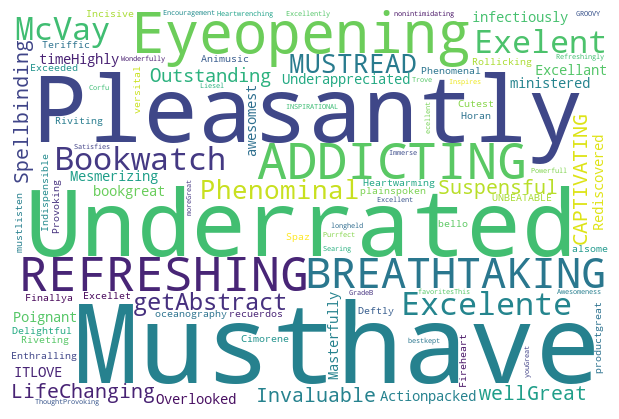

In [32]:
palavras_positivas = " ".join(palavra[0] for palavra in maior_positividade)
wordcloud = WordCloud(width = 600, height = 400,
                background_color ='white', collocations = False).generate(palavras_positivas)

plt.figure(figsize = (6, 4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

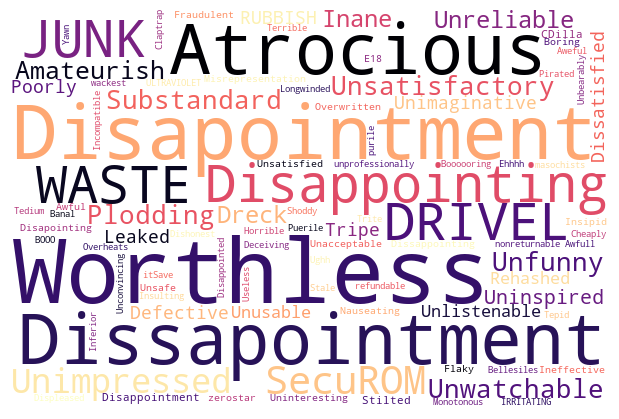

In [33]:
palavras_negativas = " ".join(palavra[0] for palavra in maior_negatividade)
wordcloud_neg = WordCloud(width = 600, height = 400,
                background_color ='white', collocations = False,
                colormap="magma").generate(palavras_negativas)

plt.figure(figsize = (6, 4), facecolor = None)
plt.imshow(wordcloud_neg)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### Tarefa desafio!

Qual o desempenho do classificador (acurácia)? Para medir sua acurácia:

- Separe os reviews em dois conjuntos: treinamente e teste
- Repita o "treinamento" do classificador com o conjunto de treinamento
- Para cada review do conjunto de teste, determine se é positiva ou negativa de acordo com o classificador
- Determine a acurácia

Esta não é uma tarefa trivial. Não basta fazer um `for` para determinar a classe de cada review de teste: isso demoraria uma eternidade. Você tem que usar variáveis "broadcast" do Spark para enviar uma cópia da tabela de frequencias para cada *core* do executor.

In [9]:
treinamento, teste = rdd.randomSplit([0.8, 0.2], 42)

In [10]:
rdd_pos_treino, rdd_neg_treino = split_pos_neg(treinamento)

In [11]:
treinamento_pos_log_count, treinamento_total_pos = log_count(par_palavra_contagem(rdd_pos_treino))
treinamento_neg_log_count, treinamento_total_neg = log_count(par_palavra_contagem(rdd_neg_treino))

In [12]:
treinamento_pos_neg_log = outerjoin_rdd(treinamento_pos_log_count, treinamento_neg_log_count)

In [13]:
list_words_pos_neg_log_treino = treinamento_pos_neg_log.collect()

In [14]:
dict_palavra_sentimento_treino = {}
for palavra in list_words_pos_neg_log_treino:
    dict_palavra_sentimento_treino[palavra[0]] = (palavra[1], palavra[2])

In [15]:
dict_palavra_sentimento_treino["anything"]

(-3.513412440358419, -3.2410510676962585)

In [16]:
qnt_pos, qnt_neg = qnt_sentimentos(treinamento)
qnt_total_treino = treinamento.count()
values = [qnt_pos, qnt_neg, qnt_total_treino]

In [17]:
broadcastTreino = sc.broadcast(dict_palavra_sentimento_treino)

In [18]:
broadcastQntValues = sc.broadcast(values)

In [20]:
from functools import *

def broadcasted_get_word_prob(word):
    try:
        prob = broadcastTreino.value[word]
        if prob[0] == None:
            prob[0] = 0
        if prob[1] == None:
            prob[1] = 0
        return prob
    except:
        return (0,0)
    

def broadcasted_Naive_Bayes(item):
    res = reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]),map(lambda x: broadcasted_get_word_prob(x), item[1]))
    prob_final = (res[0] + np.log10(broadcastQntValues.value[0]/broadcastQntValues.value[2]), res[1] + np.log10(broadcastQntValues.value[1]/broadcastQntValues.value[2]))
    if prob_final[0] < prob_final[1]:
        return (item[0], 1)
    else:
        return (item[0], 2)

In [21]:
def divide_word_rdd(rdd):
    return rdd.map(lambda x:(x[0], divide_words(x)))
                   
def NB_predict(rdd):
    return rdd.map(lambda x: broadcasted_Naive_Bayes(x))

In [22]:
rdd_divide_words = divide_word_rdd(teste)

In [23]:
rdd_divide_words.count()

720340

In [24]:
rdd_result = NB_predict(rdd_divide_words)

### ERRO: Estouro de Memória

Abaixo, as três próximas células, quando o algoritmo de Nayve Bayes é aplicado em todo o RDD, a memória RAM do nosso computador não aguenta. Portanto, precisei subir muito a quantidade de recursos alocados para o docker. **Cuidado quando for rodar novamente**

In [25]:
def accuracy_NaiveBayes(rdd, tamanho_teste):
    return rdd.filter(lambda x: x[0] == x[1]).count()/tamanho_teste

In [26]:
tamanho_teste = teste.count()

In [27]:
accuracy = accuracy_NaiveBayes(rdd_result, tamanho_teste)

In [28]:
print(f'A acurácia do modelo foi de: {round(accuracy*100, 2)}%')

A acurácia do modelo foi de: 85.67%


### Tarefa desafio!

Implemente Laplace smoothing

In [29]:
alpha = 1
total_palavras_voc_ingl = 250000

def log_count_laplace(rdd):
    total = rdd.map(lambda x: x[1]).sum()
    return rdd.map(lambda x: (x[0], np.log10((x[1] + alpha)/(total + alpha*total_palavras_voc_ingl)))), total

In [30]:
treinamento_laplace, teste_laplace = rdd.randomSplit([0.8, 0.2], 42)

In [31]:
rdd_pos_treino_laplce, rdd_neg_treino_laplce = split_pos_neg(treinamento_laplace)

In [32]:
rdd_pos_log_count_laplace, treino_total_pos_laplace = log_count_laplace(par_palavra_contagem(rdd_pos_treino_laplce))
rdd_neg_log_count_laplace, treino_total_neg_laplace = log_count_laplace(par_palavra_contagem(rdd_neg_treino_laplce))

In [33]:
rdd_pos_neg_log_laplace = outerjoin_rdd(rdd_pos_log_count_laplace, rdd_neg_log_count_laplace)

In [34]:
list_words_pos_neg_log_laplace = rdd_pos_neg_log_laplace.collect()

In [35]:
dict_palavra_sentimento_treino_laplace = {}
for palavra in list_words_pos_neg_log_laplace:
    dict_palavra_sentimento_treino_laplace[palavra[0]] = (palavra[1], palavra[2])

In [36]:
qnt_pos_treino_laplace, qnt_neg_treino_laplace = qnt_sentimentos(treinamento)
qnt_total_treino_laplace = treinamento.count()
values_qnt_laplace = [qnt_pos_treino_laplace, qnt_neg_treino_laplace, qnt_total_treino_laplace]

In [37]:
broadcastTreinoLaplace = sc.broadcast(dict_palavra_sentimento_treino_laplace)

In [38]:
broadcastQntValuesLaplace = sc.broadcast(values_qnt_laplace)

In [39]:
from functools import *

def broadcasted_get_word_prob_laplace(word):
    try:
        prob = broadcastTreinoLaplace.value[word]
        if prob[0] == None:
            prob[0] = np.log10(alpha/(alpha*total_palavras_voc_ingl))
        if prob[1] == None:
            prob[1] = np.log10(alpha/(alpha*total_palavras_voc_ingl))
        return prob
    except:
        return (np.log10(alpha/(alpha*total_palavras_voc_ingl)),np.log10(alpha/(alpha*total_palavras_voc_ingl)))
    

def broadcasted_Naive_Bayes_laplace(item):
    res = reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]),map(lambda x: broadcasted_get_word_prob_laplace(x), item[1]))
    prob_final = (res[0] + np.log10(broadcastQntValuesLaplace.value[0]/broadcastQntValuesLaplace.value[2]), res[1] + np.log10(broadcastQntValuesLaplace.value[1]/broadcastQntValuesLaplace.value[2]))
    if prob_final[0] < prob_final[1]:
        return (item[0], 1)
    else:
        return (item[0], 2)

In [40]:
def NB_laplace_predict(rdd):
    return rdd.map(lambda x: broadcasted_get_word_prob_laplace(x))

In [41]:
rdd_divide_words_laplace = divide_word_rdd(teste_laplace)

In [42]:
rdd_divide_words_laplace.count()

720340

In [43]:
rdd_result_laplace = NB_predict(rdd_divide_words_laplace)

In [44]:
tamanho_teste_laplace = teste_laplace.count()

In [45]:
accuracy_laplace = accuracy_NaiveBayes(rdd_result_laplace, tamanho_teste_laplace)

In [46]:
print(f'A acurácia do modelo com laplace foi de: {round(accuracy_laplace*100, 2)}%')

A acurácia do modelo com laplace foi de: 85.67%


## Rubrica de avaliação

- I: groselha, falha crítica, ou não entregou nada
- D: Fez uma tentativa honesta de fazer todos os itens da fase 1, mas tem erros
- C: Fase 1 completa
- B: Fase 2, faltando apenas um desafio
- A: Fase 2 completa